# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>
<br>
<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>
<br>
<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>
<br>
<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>
<br>
Document your work, evaluate the results, and analyse the outcomes in each subtasks 3.1-3.3.

</div>

## Run task one first to get training and testing records (Task 1.2)
If you have run task one yourself before you can skip following cell

In [1]:
%%capture
%run ./slovo_one.ipynb

In [2]:
#Get the training data form the notebook slovo_one:
%store -r training_records
training_records = training_records
%store -r testing_records
testing_records = testing_records

In [3]:
# Task 3 imports
import pandas as pd
import numpy as np
import time
from copy import deepcopy
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import importlib, utilities.fun_three, utilities.fun_two, utilities.fun_one
importlib.reload(utilities.fun_three)
importlib.reload(utilities.fun_two)
importlib.reload(utilities.fun_one)
from utilities.fun_three import reshape_dataframe, Normalizer, merge_dataframes
from utilities.fun_two import *
from utilities.fun_one import visualize

## Task 3.1 Prepare the PCA with 10 components and channel means and stds for the accelerometer data

#### Firstly resample the data
(Similarity to the task 2.1)

In [4]:
### Your code begins here ###
# Resample data:
start_time = time.time()
# number of samples to be left in a window
resample_samples = 125
# Resample training data using signal's resample:
act_train = pd.DataFrame()
act_train['df'] = acccelerometer_resample(training_records,resample_samples)
train_labels = training_records[training_records.sensor_code=='act'].exercise_id.apply(lambda x: int(x))
# Resample testing data:
act_test = pd.DataFrame()
act_test['df'] = acccelerometer_resample(testing_records,resample_samples)
#Get Labels:
test_labels = testing_records[testing_records.sensor_code=='act'].exercise_id.apply(lambda x: int(x))
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  1.2975208759307861


#### Secondly perform the data standardization
(Similarity to the task 2.1)

In [5]:
#Standardize the Data:
start_time = time.time()
# Create a Standardizer:
act_s = Standardizer()
# Calculate mean and std on training set:
act_s.fit(act_train)
# Using mean and std standardize training and test sets:
act_train['df'] = act_s.transform(act_train)
act_test['df'] = act_s.transform(act_test)
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.7495050430297852


#### Thirdly calculate the PCA

In [6]:
# PCA:
start_time = time.time()
# choose 10 principal components:
n_components = 10
# Create Pca decorator class object:
pca = PcaActApplier(n_components)
# Fit the PCA with the training data
pca.fit(act_train['df'])
# Apply PCA on both training and testing data:
act_pca_train = pca.transform(act_train['df'])
act_pca_test = pca.transform(act_test['df'])
end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  13.02764105796814


#### Concatenate accelerometer data features
We have 10 PCA components * 3 channels + mean and std form each channel = vector of 36 values per row

In [7]:
start_time = time.time()
# Create training accelerometer features np array:
act_features = np.concatenate((act_pca_train[0],act_pca_train[1],act_pca_train[2],
                               np.mean(act_pca_train[0],axis=1).reshape(-1,1), np.std(act_pca_train[0],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[1],axis=1).reshape(-1,1), np.std(act_pca_train[1],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[2],axis=1).reshape(-1,1), np.std(act_pca_train[2],axis=1).reshape(-1,1),
                              ),axis=1)
# Create testing accelerometer features np array:
act_test_features = np.concatenate((act_pca_test[0],act_pca_test[1],act_pca_test[2],
                                    np.mean(act_pca_test[0],axis=1).reshape(-1,1), np.std(act_pca_test[0],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[1],axis=1).reshape(-1,1), np.std(act_pca_test[1],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[2],axis=1).reshape(-1,1), np.std(act_pca_test[2],axis=1).reshape(-1,1),
                                   ),axis=1)

# Create the dataframes from the np arrays:
pca_act_training_records_reshaped = deepcopy(training_records[training_records.sensor_code=='act'])
pca_act_training_records_reshaped["df"] = [act_feature for act_feature in act_features]
pca_act_training_records_reshaped["df"] = pca_act_training_records_reshaped.df.apply(np.expand_dims,axis=0)

pca_act_testing_records_reshaped = deepcopy(testing_records[testing_records.sensor_code=='act'])
pca_act_testing_records_reshaped["df"] = [act_test_feature for act_test_feature in act_test_features]
pca_act_testing_records_reshaped["df"] = pca_act_testing_records_reshaped.df.apply(np.expand_dims,axis=0)

end_time = time.time()
print("Execution Time: ", end_time - start_time)
### Your code ends here ###

Execution Time:  0.010260820388793945


## Task 3.2 Calculate PCA with 10 features for depth sensor data

#### Firstly resample the data
(Similarity to the task 2.2)

In [8]:
# 3.2
### Your code begins here ###
'''Work only with rows with dc'''
dc_train_records = training_records[training_records['sensor'] == 'dc']
dc_test_records = testing_records[testing_records['sensor'] == 'dc']

'''Initialize PCA for depth senspr'''
reduced_dimensions = 10
pca_applier = PcaDcApplier(reduced_dimensions)

#### Secondly perform the data standardization
(Similarity to the task 2.2)

In [9]:
start_time = time.time()

'''Standardize the dc data'''
standardizer = Standardizer()
standardizer.fit(dc_train_records)
standardized_dc_train_records = standardizer.transform(dc_train_records)
standardized_dc_test_records = standardizer.transform(dc_test_records)

end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  1.4511699676513672


#### Thirdly calculate the PCA

In [10]:
start_time = time.time()

'''Fit and transform PCA'''
pca_applier.fit(standardized_dc_train_records)

pca_dc_train_records = pca_applier.transform(standardized_dc_train_records)
pca_dc_test_records = pca_applier.transform(standardized_dc_test_records)

end_time = time.time()
print("Execution Time: ", end_time - start_time)


Execution Time:  13.010798692703247


#### Concatenate depth sensor data features by reshaping the 'df' dataframe
We have 10 PCA components * 5 image samples = vector of 50 values per row

In [11]:
start_time = time.time()

'''Reshape the dataframes for both train and test datasets '''
pca_dc_train_records_reshaped = deepcopy(pca_dc_train_records)
pca_dc_train_records_reshaped["df"] = pca_dc_train_records_reshaped["df"].apply(reshape_dataframe)
dc_features = np.concatenate(pca_dc_train_records_reshaped['df'].values,axis=0)

pca_dc_test_records_reshaped = deepcopy(pca_dc_test_records)
pca_dc_test_records_reshaped["df"] = pca_dc_test_records_reshaped["df"].apply(reshape_dataframe)
dc_test_features = np.concatenate(pca_dc_test_records_reshaped['df'].values,axis=0)

end_time = time.time()
print("Execution Time: ", end_time - start_time)
### Your code ends here ###

Execution Time:  0.015630006790161133


## 3.3 Merge Accelerometer and Depth sensor PCA features

In [12]:
import importlib, utilities
importlib.reload(utilities.fun_one)
from utilities.fun_one import visualize

#### Merge Accelerometer and Depth sensor PCA features

Row index can't be used, as it's unique for each modality. Merge over 'subject_id', 'exercise_id', 'trial', 'window_idx' is done instead assuring, that Accelerometer and Depth sensor data are alligned properly. Merged data feature vector is of shape 1*86. 50 features from Depth sensor and 36 from Accelerometer.

In [13]:
start_time = time.time()
# 3.3
### Your code begins here ###

train_records_merged = pca_dc_train_records_reshaped.merge(pca_act_training_records_reshaped, on=['subject_id', 'exercise_id', 'trial', 'window_idx']).apply(merge_dataframes, axis=1)
test_records_merged = pca_dc_test_records_reshaped.merge(pca_act_testing_records_reshaped, on=['subject_id', 'exercise_id', 'trial', 'window_idx']).apply(merge_dataframes, axis=1)

end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.5975139141082764


In [14]:
#Save data for use in other notebooks:
%store train_records_merged
%store test_records_merged

Stored 'train_records_merged' (DataFrame)
Stored 'test_records_merged' (DataFrame)


#### Normalize the data with Normalizer
Min-max normalization of the merged data. Min and max are calculated for each feature in the feature vector to avoid bias among features.

In [15]:
start_time = time.time()

'''Normalize the features'''
normalizer = Normalizer()
normalizer.fit(train_records_merged)

normalized_train_records = normalizer.transform(train_records_merged)
normalized_test_records = normalizer.transform(test_records_merged)

end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.4952230453491211


#### Initialization and training of the classifiers

SVM and Gausian Naive Bayes classifiers are chosen for the classification.

In [16]:
start_time = time.time()

'''Initialize and fit classifiers on training data'''
gnb_classifier = GaussianNB()
svm_classifier = SVC()

gnb_classifier.fit(np.concatenate(normalized_train_records['df_normalized'].values,axis=0), normalized_train_records['exercise_id'].values)
svm_classifier.fit(np.concatenate(normalized_train_records['df_normalized'].values,axis=0), normalized_train_records['exercise_id'].values)

end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.07708382606506348


In [17]:
start_time = time.time()

'''Get classifier predictions for test and train datasets'''
gnb_est_train_labels = gnb_classifier.predict(np.concatenate(normalized_train_records['df_normalized'].values,axis=0))
gnb_est_test_labels = gnb_classifier.predict(np.concatenate(normalized_test_records['df_normalized'].values,axis=0))

svm_est_train_labels = svm_classifier.predict(np.concatenate(normalized_train_records['df_normalized'].values,axis=0))
svm_est_test_labels = svm_classifier.predict(np.concatenate(normalized_test_records['df_normalized'].values,axis=0))

end_time = time.time()
print("Execution Time: ", end_time - start_time)

Execution Time:  0.3274078369140625


GNB merged
Training data F1 score =  0.9265680499763242
Testing data F1 score =  0.6454697703182352
SVM merged
Training data F1 score =  0.9986497395730825
Testing data F1 score =  0.617004285575475


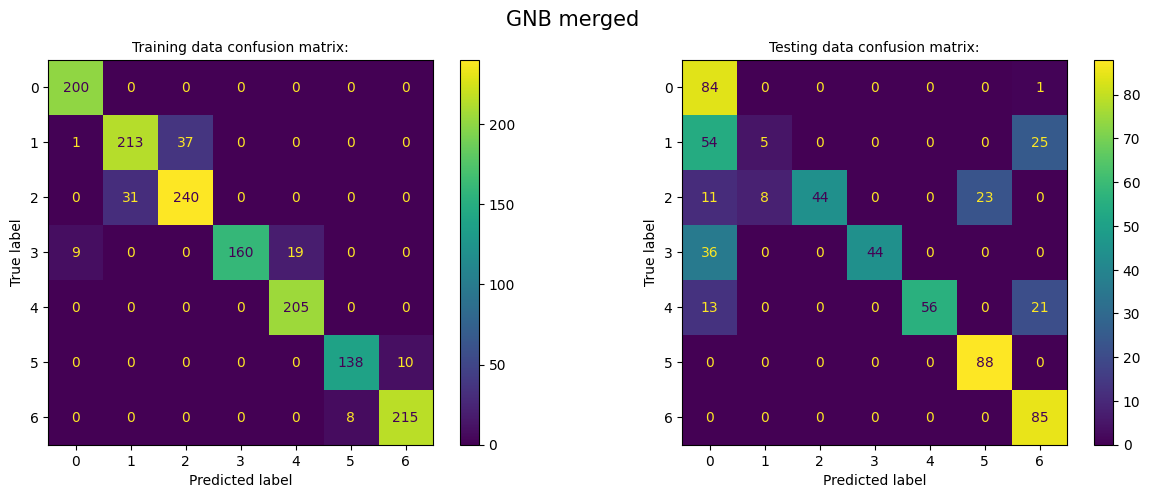

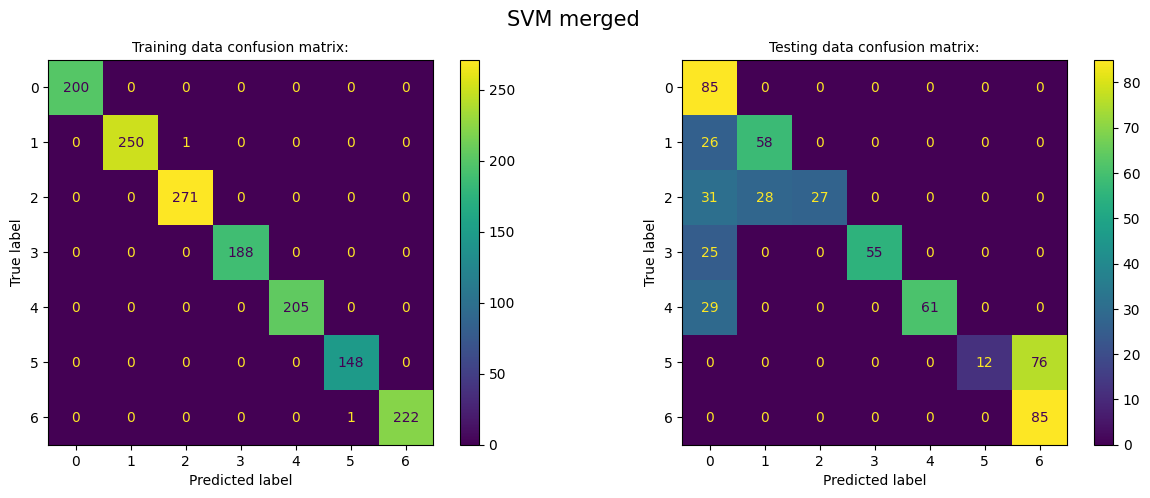

In [18]:
'''Visualize classification results. First for Gaussian naiveBayes classifier, then for SVM classifier'''
visualize(gnb_est_train_labels,
          normalized_train_records['exercise_id'].values,
          gnb_est_test_labels,
          normalized_test_records['exercise_id'].values,
          main_title="GNB merged")

visualize(svm_est_train_labels,
          normalized_train_records['exercise_id'].values,
          svm_est_test_labels,
          normalized_test_records['exercise_id'].values,
          main_title="SVM merged")

### Your code ends here ###

## Task 3.3 review

As suggested in the review of Task 2.2, performances of classifiers on fused modalites data are much better, than the performance of the NN classifier on the data of separated modalities. Although 64% F1 score may still not be usable in the real world application improvement of almost 20% is big step forward. That's because of modality fusion and also more sophisticated classifier algorithms.

SVM classifier classified almost 100% of training data correctly (unlike GNB with only "92%"), but the performance on the testing data was lower than GNB. This is probably the sign of over-fitted SVM to the training the data. Tuning the parrameters of the classifiers could improve the performance on the testing data even further.
